In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sys
sys.path.insert(0, os.environ['PLOT_SETTINGS_DIR'])
import plot_settings
import matplotlib.ticker as tk
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']= 'STIXGeneral'
mpl.rcParams['mathtext.fontset']= 'stix'
mpl.rcParams['font.size']= 24


In [3]:
df

,prob,blocks,tstop,epoch,beta0,beta1,mean_gs,std_gs,cities,feasible,epoch_real,sync_frequency,Bandwidth (Gbps),Subsystems,"Sync Frequency ($\tau^{-1}$, MHz)"
0,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,20,True,1.862645e-10,5.368709e+09,1000.0,2,5368.709120
1,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,20,False,1.862645e-10,5.368709e+09,1000.0,2,5368.709120
2,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,20,False,1.862645e-10,5.368709e+09,1000.0,2,5368.709120
3,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,20,True,1.862645e-10,5.368709e+09,1000.0,2,5368.709120
4,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,20,True,1.862645e-10,5.368709e+09,1000.0,2,5368.709120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479995,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,35,False,5.704351e-07,1.753048e+06,1.0,8,1.753048
479996,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,35,False,5.704351e-07,1.753048e+06,1.0,8,1.753048
479997,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,35,False,5.704351e-07,1.753048e+06,1.0,8,1.753048
479998,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,35,False,5.704351e-07,1.753048e+06,1.0,8,1.753048


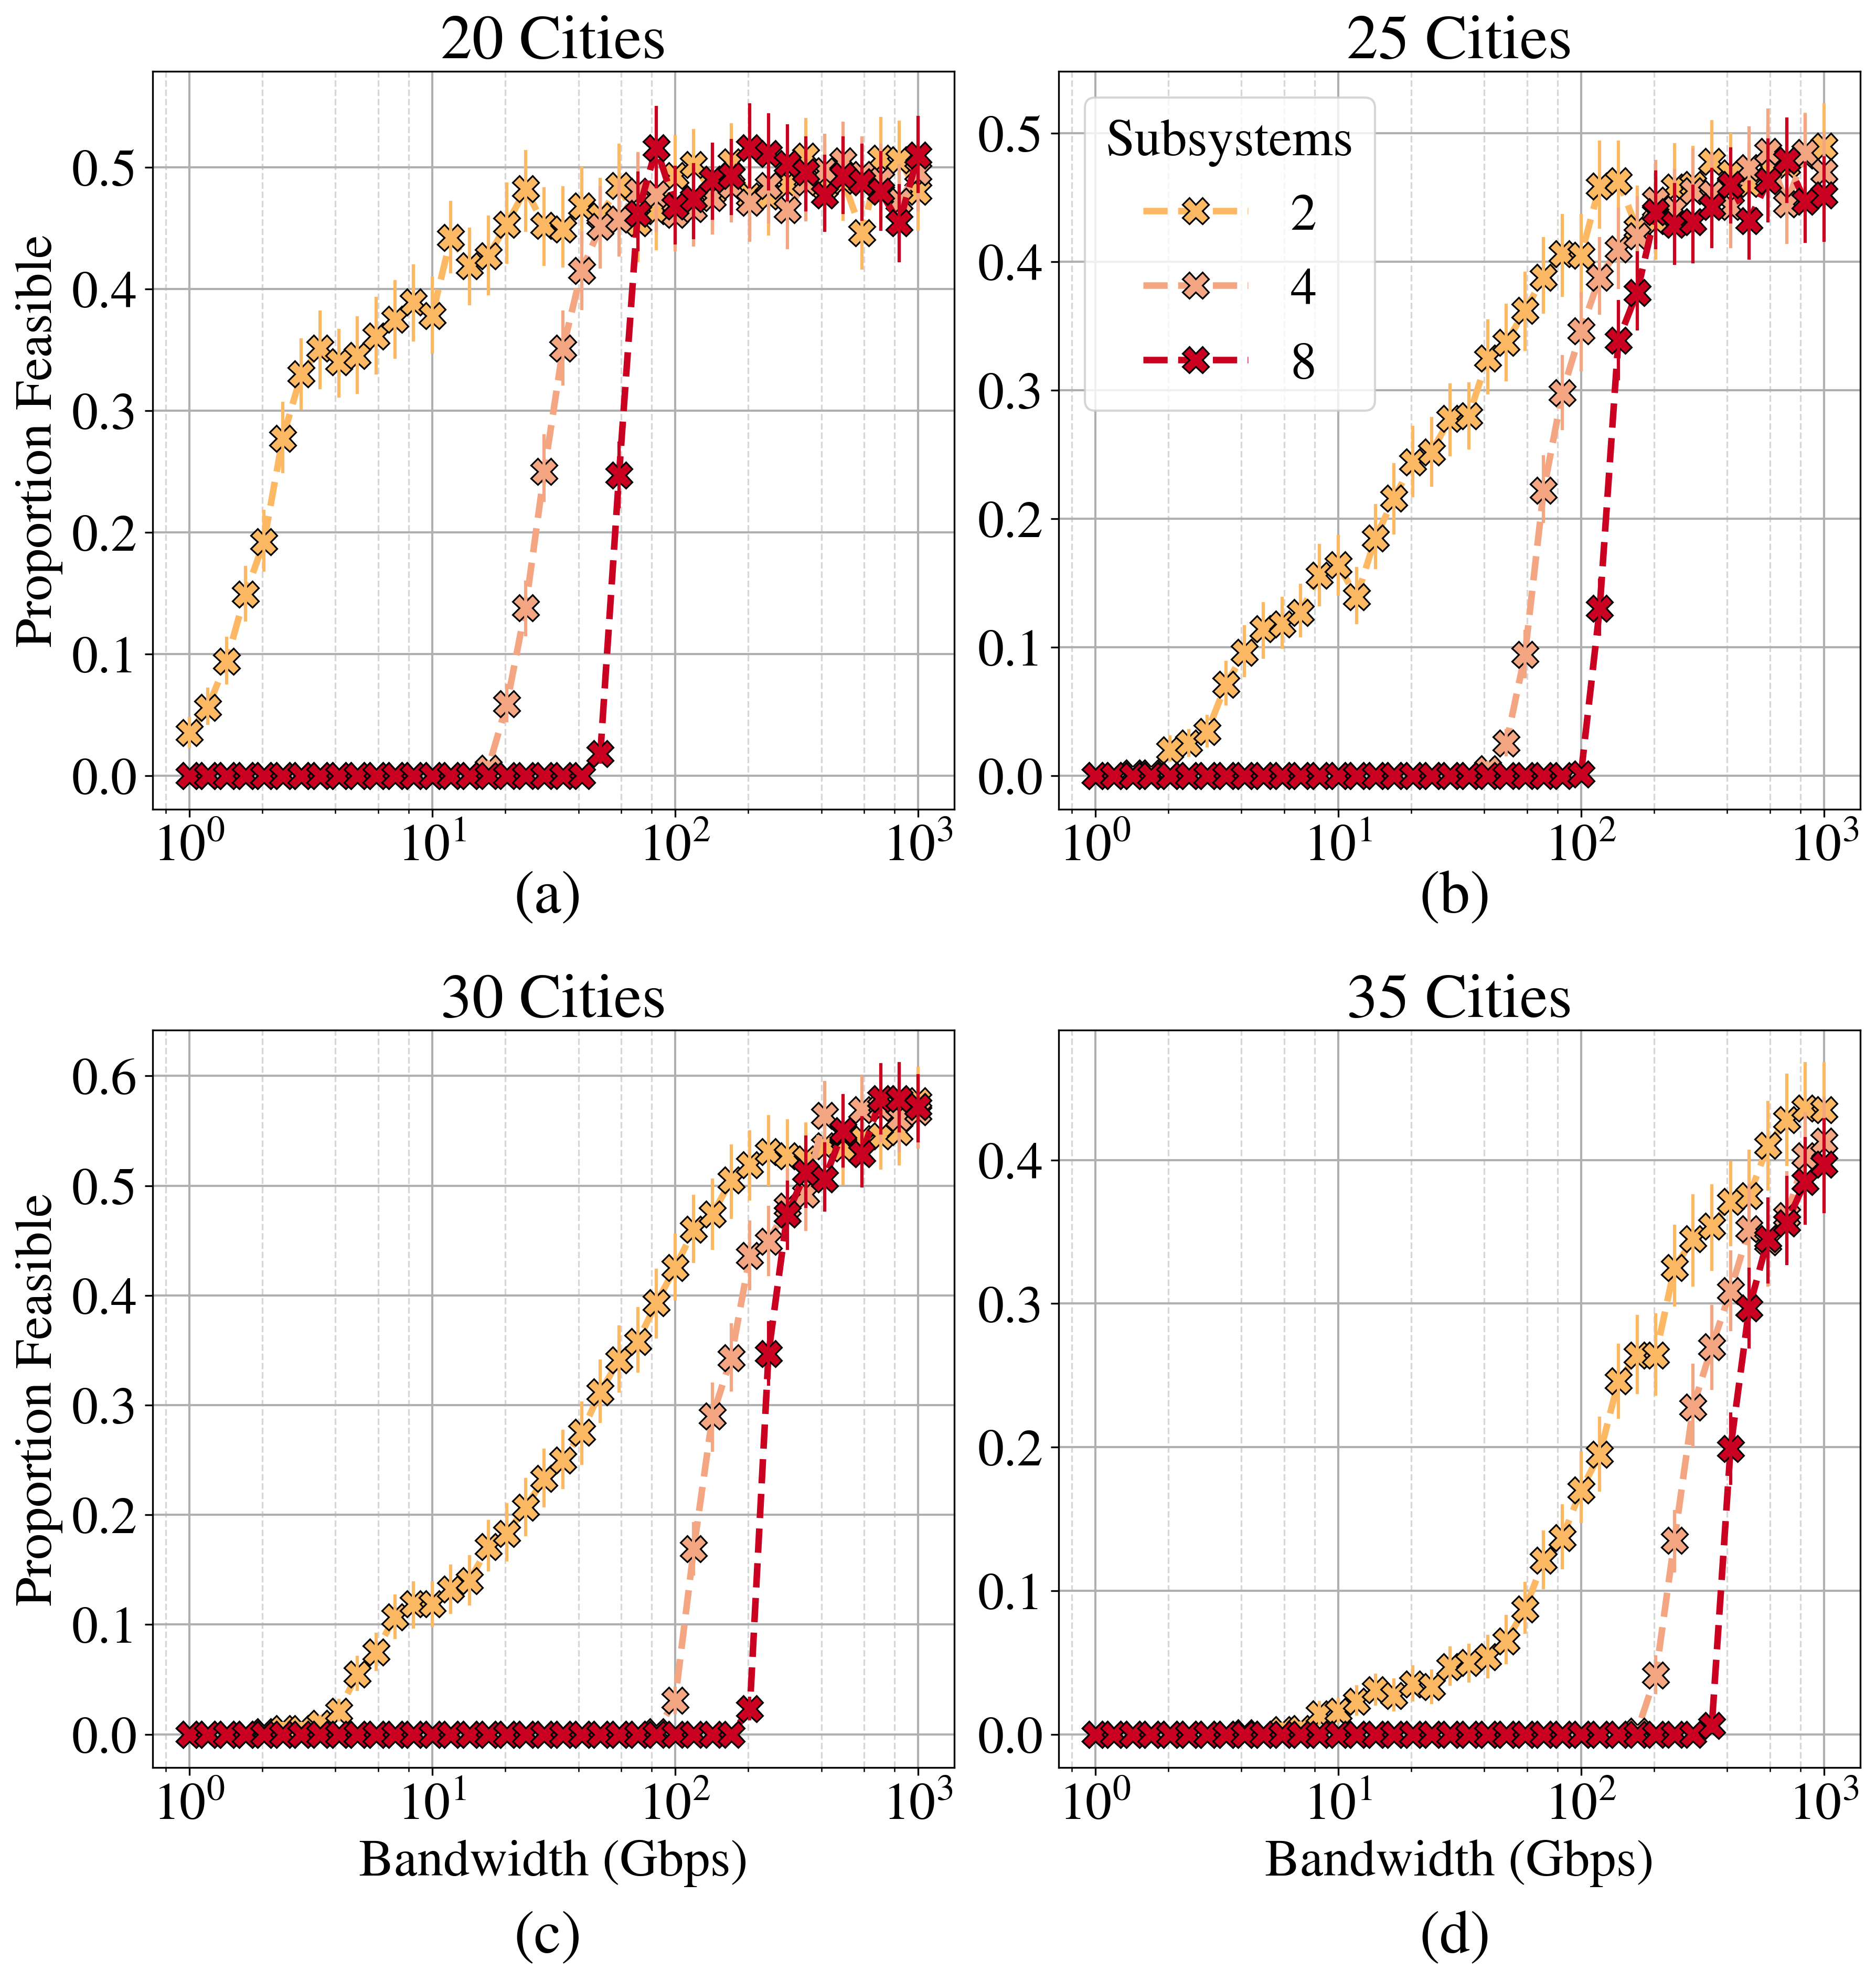

In [4]:
df = pd.read_csv('../rng_euc2d_feasibility.csv')
df['Subsystems'] = df['blocks']
df['Sync Frequency ($\\tau^{-1}$, MHz)'] = 1 / df['epoch'] / (31e4*50e-15) / 1e6
# mpl.rcParams['font.size'] = 20
palette = [ 
#     "#404040",
            "#fdb863",
            "#f4a582",
            "#ca0020",]
kwargs = dict(
    hue='Subsystems', x='Bandwidth (Gbps)', y='feasible', palette=palette,
    linestyle='--',
    marker='X',
    markersize=12,
    linewidth=3,
    err_style='bars',
    markeredgecolor='black',
    # palette=palette

)
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14, 14), dpi=300, gridspec_kw={'hspace': 0.3, 'wspace': 0.13})
ax=axs[0][0]
sns.lineplot(ax=ax, data=df.query('cities==20'), **kwargs)
ax.set_xscale('log')
ax.set_title(f'20 Cities')

ax=axs[0][1]
sns.lineplot(ax=ax, data=df.query('cities==25'), **kwargs)
ax.set_xscale('log')
ax.set_title(f'25 Cities')

ax=axs[1][0]
sns.lineplot(ax=ax, data=df.query('cities==30'), **kwargs)
ax.set_xscale('log')
ax.set_title(f'30 Cities')

ax=axs[1][1]
sns.lineplot(ax=ax, data=df.query('cities==35'), **kwargs)
ax.set_xscale('log')
ax.set_title(f'35 Cities')
for ax in axs.flatten():
    ax.set_ylabel('Proportion Feasible')
    ax.grid()
for ax, label in zip(axs[0], ['a', 'b']):
    ax.set_xlabel('')
    ax.annotate(text=f"({label})", xy=(0.45, -0.14), xycoords='axes fraction', fontsize=28)
for ax, label in zip(axs[1], ['c', 'd']):
    ax.annotate(text=f"({label})", xy=(0.45, -0.25), xycoords='axes fraction', fontsize=28)
axs[0][1].set_ylabel('')
axs[1][1].set_ylabel('')
axs[0][0].legend_ = None
axs[1][1].legend_ = None
axs[1][0].legend_ = None
for ax in axs.flatten():
    ax.grid(which='minor', linestyle='--', alpha=0.5)
    ax.grid(which='major', linewidth=1)
    # ax.yaxis.set_major_locator(tk.LogLocator(base=10, subs=[1]))
    # ax.yaxis.set_minor_locator(tk.LogLocator(base=10, subs=[2, 4, 6, 8]))
    ax.xaxis.set_major_locator(tk.LogLocator(base=10, subs=[1]))
    ax.xaxis.set_minor_locator(tk.LogLocator(base=10, subs=[2, 4, 6, 8]))
fig.savefig('../figures/feasibility_concurrent.pdf', bbox_inches='tight', dpi=300)